In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from utils import generate_train_val_ds, get_image_size
from PIL import Image
from loss_funcs import LOSS_FUNCS
from optimizers import OPTIMIZERS
from keras import metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from loss_funcs import LOSS_FUNCS
from optimizers import OPTIMIZERS
# from google.colab import drive


In [14]:
# drive.mount("/content/drive")

In [15]:
# Сделать приём путей от сервера.

# train_dir = "/content/drive/My Drive/cervix_cancer_data/train/"
# test_dir = "/content/drive/My Drive/cervix_cancer_data/test2_resized/"
# val_dir = "/content/drive/My Drive/cervix_cancer_data/val/"
# data_dir = "/content/drive/My Drive/cervix_cancer_data/"

train_dir = "train/"
test_dir = "test2_resized/"
val_dir = "val/"


In [17]:
random_class = os.listdir(train_dir)[1]
random_image_name = os.listdir(train_dir + random_class)[0]
random_image = Image.open(train_dir + random_class + "/" + random_image_name)
default_image_size = get_image_size(random_image)

In [18]:
batch_size = 32
img_height = default_image_size
img_width = default_image_size

In [19]:
# train_ds = tf.keras.utils.image_dataset_from_directory(
#     train_dir, 
#     seed=123,
#     image_size=(img_height, img_width), 
#     batch_size=batch_size
#     )

In [20]:
# val_ds = tf.keras.utils.image_dataset_from_directory(
#     val_dir, 
#     seed=123,
#     image_size=(img_height, img_width), 
#     batch_size=batch_size
#     )

In [21]:
train_ds, val_ds = generate_train_val_ds(train_dir, (img_height, img_width), batch_size)

Found 982 files belonging to 3 classes.
Using 786 files for training.


2023-02-04 17:30:56.342997: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 982 files belonging to 3 classes.
Using 196 files for validation.


In [22]:
class_names = train_ds.class_names
class_names

['Type_1', 'Type_2', 'Type_3']

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [27]:
num_classes = len(class_names)

sequential_layers = [
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
]

In [51]:
models = {}
epochs = 10


for optimizer in OPTIMIZERS:
    for loss_func in LOSS_FUNCS:
        optimizer_name = str(optimizer).split(".")[-1].split(" ")[0]
        print(optimizer_name + " " + loss_func.name)

        model = Sequential(sequential_layers)

        model.compile(optimizer=optimizer,
              loss=loss_func,
              metrics=['accuracy'])
        
        history = model.fit(
                          train_ds,
                          validation_data=val_ds,
                          epochs=epochs
                            )
        models[optimizer_name + " " + loss_func.name] = model
        
        del model
        tf.keras.backend.clear_session()
        

Adam sparse_categorical_crossentropy
Epoch 1/10
25/25 [==============================] - 20s 693ms/step - loss: 0.7670 - accuracy: 0.6667 - val_loss: 1.1683 - val_accuracy: 0.4745
Epoch 2/10
25/25 [==============================] - 18s 708ms/step - loss: 0.7549 - accuracy: 0.6578 - val_loss: 1.2974 - val_accuracy: 0.4796
Epoch 3/10
25/25 [==============================] - 17s 683ms/step - loss: 0.6978 - accuracy: 0.7023 - val_loss: 1.3959 - val_accuracy: 0.4541
Epoch 4/10
25/25 [==============================] - 17s 689ms/step - loss: 0.6726 - accuracy: 0.6997 - val_loss: 1.3187 - val_accuracy: 0.5051
Epoch 5/10
25/25 [==============================] - 17s 697ms/step - loss: 0.6594 - accuracy: 0.7239 - val_loss: 1.4569 - val_accuracy: 0.4745
Epoch 6/10
25/25 [==============================] - 18s 704ms/step - loss: 0.6332 - accuracy: 0.7290 - val_loss: 1.4434 - val_accuracy: 0.4847
Epoch 7/10
25/25 [==============================] - 17s 687ms/step - loss: 0.6125 - accuracy: 0.7188 - va

25/25 [==============================] - 23s 741ms/step - loss: 0.9839 - accuracy: 0.5382 - val_loss: 1.0564 - val_accuracy: 0.5204
Epoch 2/10
25/25 [==============================] - 19s 765ms/step - loss: 0.8904 - accuracy: 0.5878 - val_loss: 1.0695 - val_accuracy: 0.5357
Epoch 3/10
25/25 [==============================] - 24s 947ms/step - loss: 0.8357 - accuracy: 0.6132 - val_loss: 1.1188 - val_accuracy: 0.5051
Epoch 4/10
25/25 [==============================] - 22s 880ms/step - loss: 0.8067 - accuracy: 0.6272 - val_loss: 1.1873 - val_accuracy: 0.4337
Epoch 5/10
25/25 [==============================] - 21s 845ms/step - loss: 0.7563 - accuracy: 0.6692 - val_loss: 1.1882 - val_accuracy: 0.4643
Epoch 6/10
25/25 [==============================] - 21s 847ms/step - loss: 0.6883 - accuracy: 0.7023 - val_loss: 1.3645 - val_accuracy: 0.4541
Epoch 7/10
25/25 [==============================] - 20s 816ms/step - loss: 0.7047 - accuracy: 0.6972 - val_loss: 1.5844 - val_accuracy: 0.3724
Epoch 8/10

In [52]:
def get_best_model_and_metrics():
    prev = 0
    best_model = None
    
    for model in models:
        preds = tf.nn.softmax(models[model].predict(val_ds))
        y_pred = np.argmax(preds, axis=1)
        report = classification_report(val_labels, y_pred, target_names=class_names, output_dict=True)
                
        if report["weighted avg"]["f1-score"] > prev:
            prev = report["weighted avg"]["f1-score"]
            best_model = model
            
    return models[best_model], report

Adam sparse_categorical_crossentropy
7/7 [==============================] - 2s 193ms/step
0.4809801153626819
Nadam sparse_categorical_crossentropy
7/7 [==============================] - 1s 156ms/step
0.4809801153626819
Adam sparse_categorical_crossentropy


In [53]:

# Получение лейблов по загруженному датасету
val_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Демонстрация метрик
preds = models["Adam sparse_categorical_crossentropy"].predict(val_ds)
preds = tf.nn.softmax(preds)

y_pred = np.argmax(preds, axis=1)

report1 = classification_report(val_labels, y_pred, target_names=class_names, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

7/7 [==============================] - 1s 147ms/step


,precision,recall,f1-score,support
Type_1,0.352941,0.142857,0.203390,42.000000
Type_2,0.540984,0.660000,0.594595,100.000000
Type_3,0.473684,0.500000,0.486486,54.000000
accuracy,0.505102,0.505102,0.505102,0.505102
macro avg,0.455870,0.434286,0.428157,196.000000
weighted avg,0.482147,0.505102,0.480980,196.000000


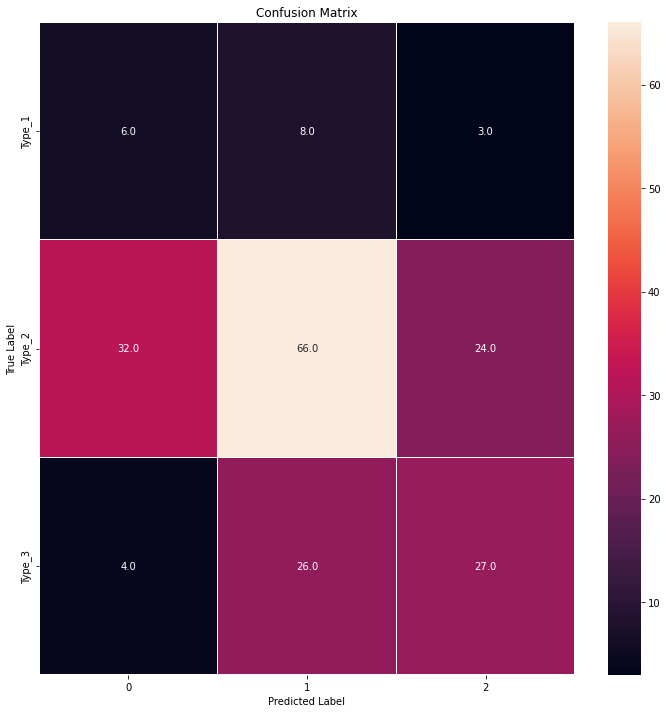

In [54]:
# Создает матрицу неточностей, надо оформить в функцию передать:
# y-pred - предсказания модели на тест выборке
# labels - правильные ответы

confusion_mtx = confusion_matrix(y_pred, val_labels)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels([0, 1, 2])
ax.yaxis.set_ticklabels(class_names)
plt.title("Confusion Matrix")
plt.show()